


## Import/Install Modules

In [ ]:
# Imports
# Basic
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn
import matplotlib
import random
import pickle as pk
import os
from scipy.stats import uniform, randint, beta

from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import spearmanr

import sys
import statsmodels
!pip install demoji
import demoji
!pip install -U sentence-transformers
!pip install umap-learn
import umap
from sentence_transformers import SentenceTransformer
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, LSTM, InputLayer, BatchNormalization, LeakyReLU, Normalization, Softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.model_selection import GridSearchCV

#!pip install scikeras==0.1.8
#from scikeras.wrappers import KerasClassifier
from keras.metrics import AUC

import xgboost as xgb
from xgboost import XGBClassifier

from scipy.stats import ttest_ind, spearmanr
from glob import glob


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 693.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 568.8 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.1 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=c1b6f63aa6d6b45410918a49afaf4ed23445cd0a58a21c6b2448370b77f62385
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 820.8 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 2.9 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=22c37b7dec740830053874b88457066defeaec205a6ae130b2f05240c23c376a
  Stored in directory: /ro

In [ ]:
# Mount your drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change directory
%cd /content/drive/MyDrive/Negatively Biased Credulity/Data/Twitter/Cleaned Data

/content/drive/MyDrive/Negatively Biased Credulity/Data/Twitter/Cleaned Data


## Install and Import Libraries

## Read Dataset

In [ ]:
#Preprocessed data
#annotations
file='Tweet annotation.csv'

data = pd.read_csv(file,low_memory=False,lineterminator='\n')


In [ ]:
# clean data
# make columns readable
data.columns = [c.replace('_1','') if not ('_' in c and 'Q' not in c) else 'Q'+c.replace('_1','') for c in data.columns]
# this question checks if someone is paying attention; everyone chose "4" so it is not needed
data = data.drop(['Q11119'],axis=1)
cols = data.columns

# where are the questions for each text located
pos_qs = [ii for ii,c in enumerate(cols) if 'Q' in c]
# number of questions per annotations
num_qs = 11
# where do the questions start (starting from the first and ending at the 10th annotation)
q_start_pos = [22-num_qs]+pos_qs[5::11]

# here we extract the exact questions
col_text = {}
for c in cols:
    col_text[c] = data.iloc[0][c]
questions = [col_text[c] for c in cols[q_start_pos[1]:q_start_pos[1]+11]]
# demographics
demogs = [col_text[c] for c in cols if 'QD' in c]
# all of the key data: text, questions, demographics per annotator
annotations = {'text':[]}
for q in questions:
    annotations[q] = []
for d in demogs:
    annotations[d] = []

# data cleaning
data = data[12:]
# find all data where humans completed the task and took > 3 minutes, 20 seconds (200 seconds)
data = data.loc[data['Progress'].astype(float).values==100,]
data = data.loc[data['Duration (in seconds)'].astype(float).values>200,]

# for each row of this file, find the exact text humans annotated
for ii,row in data.iterrows():
    if ii > 0:
        # all the tweets are those whose elements are not null and not questions
        texts = [col_text[c] for null,c in zip(row.isnull()[q_start_pos[0]+num_qs:],cols[q_start_pos[0]+num_qs:]) if not null and 'Q' not in c and c in col_text.keys()][:-4]
        line_annots = {}
        # for each text,
        for q1,text in zip(q_start_pos[1:],texts):
            # positions of all the questions associated with the text
            q_cols = cols[q1:q1+num_qs]
            # add tweet
            line_annots['text'] = [text]
            # add questions
            for q,c in zip(questions,q_cols):
                line_annots[q]=[row[c]]
            for c in cols:
                # demographic questions
                if 'QD' in c:
                    line_annots[col_text[c]]=[row[c]]
        # if we have found all the data
        if set(list(line_annots.keys()))== set(list(annotations.keys())):
            # append text, questions, demographics
            for q1,text in zip(q_start_pos[1:],texts):
                q_cols = cols[q1:q1+num_qs]
                annotations['text'].append(text)
                for q,c in zip(questions,q_cols):
                    annotations[q].append(row[c])
                for c in cols:
                    if 'QD' in c:
                        annotations[col_text[c]].append(row[c])
            lens= []
            for key in annotations.keys():
                lens.append(len(annotations[key]))
for c in annotations.keys():
    print([c,len(annotations[c])])
annotations = pd.DataFrame(annotations)





['text', 4020]
['Is this tweet spam?', 4020]
['Does the tweet describe a hazard (something that could impose harm or other costs on the author of the tweet or on others)?', 4020]
['Does the tweet provide information on how to avoid, cope with, or overcome the hazard described?', 4020]
['On a scale of 0-100, how much do you think that the author of the tweet is tweeting this information because they believe that it accurately describes a real hazard in the world, where 0 = the author does not believe that the information is accurate, and is instead sending it for some other reason (e.g., as a joke; to ridicule people who believe this sort of thing; etc.), and 100 = the author believes that the information is entirely accurate? - Author confidence', 4020]
['On a scale of 0-100, how confident is the author of the tweet that the hazard can be adequately managed, where 0 = not at all, and 100 = extremely? - Author confidence', 4020]
['Does the tweet describe a benefit (something that provid

Text(0, 0.5, '% Tweets Labeled Hazard')

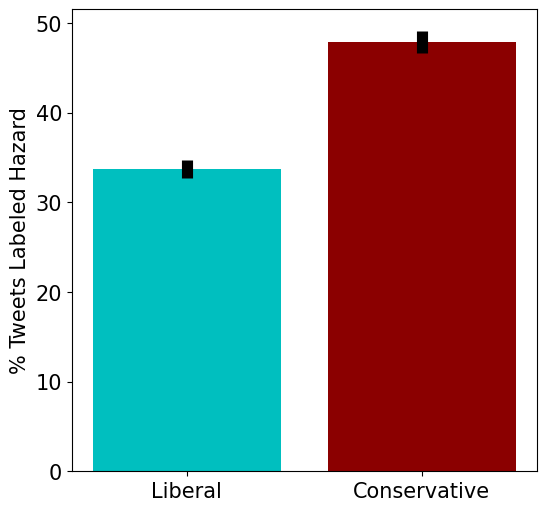

In [ ]:
#
hazard_col = 'Does the tweet describe a hazard (something that could impose harm or other costs on the author of the tweet or on others)?'
benefit_col = 'Does the tweet describe a benefit (something that provides resources, opportunities, or other good things to the author of the tweet or to others)?'

pol_col='What is your political orientation? - Political orientation'
cons=annotations.loc[annotations[pol_col].values.astype(int)>50,hazard_col].replace('Yes',1).replace('No',0)
plt.subplots(1,1,figsize=(6,6))
lib=annotations.loc[annotations[pol_col].values.astype(int)<50,hazard_col].replace('Yes',1).replace('No',0)
plt.bar([0,1],[lib.mean()*100,cons.mean()*100],color=['c','darkred'])
err = [np.sqrt((lib.mean()*100*(100-lib.mean()*100))/len(lib)),np.sqrt((cons.mean()*100*(100-cons.mean()*100))/len(cons))]
plt.errorbar([0,1],[lib.mean()*100,cons.mean()*100],yerr=err,color='k',linestyle='',linewidth=8)

plt.xticks([0,1],['Liberal','Conservative'])
plt.ylabel('% Tweets Labeled Hazard')


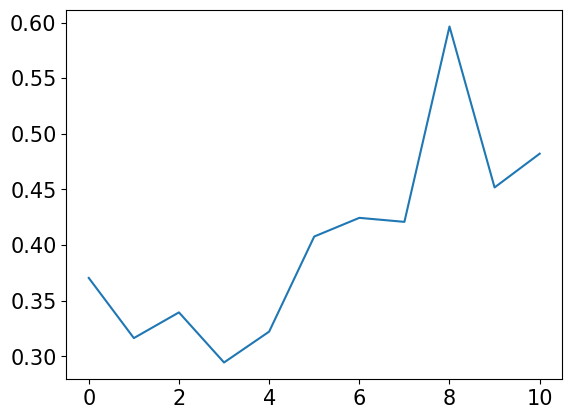

In [ ]:
pol_haz = annotations[[pol_col,hazard_col]].replace('Yes',1).replace('No',0).values.astype(float)
dc=10
pol_haz_binned = [pol_haz[(pol_haz[:,0]>=conf) & (pol_haz[:,0]<conf+dc)][:,1].mean() for conf in np.arange(0,100+dc,dc)]

plt.plot(pol_haz_binned)
#plt.plot(pol_haz[:,0],pol_haz[:,1],'k.')

In [ ]:
# convert raw data to overall annotations per text


hazard_col='Does the tweet describe a hazard (something that could impose harm or other costs on the author of the tweet or on others)?'
benefit_col = 'Does the tweet describe a benefit (something that provides resources, opportunities, or other good things to the author of the tweet or to others)?'
text_haz_ben=annotations[['text',hazard_col,benefit_col]]

text_haz_ben[hazard_col] = text_haz_ben[hazard_col].replace('Yes',1).replace('No',0).dropna()
text_haz_ben[benefit_col] = text_haz_ben[benefit_col].replace('Yes',1).replace('No',0).dropna()
unique_text = text_haz_ben['text'].drop_duplicates()
haz_ben_annots = text_haz_ben.groupby('text')
GT_labels = {'text':[],'hazard':[],'benefit':[],'old_text':[]}
for t in unique_text:
    annots = haz_ben_annots.get_group(t)
    # require at least 3 annotations
    if len(annots) < 2: continue
    ben = annots[benefit_col].values.sum()/len(annots)
    haz = annots[hazard_col].values.sum()/len(annots)
    all_replace={}
    replaced_text = []
    # replace emojis
    replace = demoji.findall(t)
    new_t = t
    for word, initial in replace.items():
        new_t = new_t.replace(word, initial)
    GT_labels['old_text'].append(t)
    GT_labels['text'].append(new_t)
    GT_labels['hazard'].append(haz)
    GT_labels['benefit'].append(ben)

GT_labels = pd.DataFrame(GT_labels)
r,p = spearmanr(GT_labels['hazard'],GT_labels['benefit'])
print([round(r,4),round(p,2)])


#Sentences are encoded by calling model.encode()
model = SentenceTransformer('stsb-xlm-r-multilingual')#'all-mpnet-base-v2')

embeddings = model.encode(GT_labels['text'].values)
GT_labels['embeddings'] = [e for e in embeddings]
fit = umap.UMAP()
trans = fit.fit(embeddings)


umap_embed = trans.transform(embeddings)

print(len(umap_embed))

<ipython-input-25-0002ed67ee90>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_haz_ben[hazard_col] = text_haz_ben[hazard_col].replace('Yes',1).replace('No',0).dropna()
<ipython-input-25-0002ed67ee90>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_haz_ben[benefit_col] = text_haz_ben[benefit_col].replace('Yes',1).replace('No',0).dropna()


[0.0651, 0.02]
1312


[link text](https://)**GPT Responses**

In [ ]:
# Dataframe sample
# GPT data
# 'threat_1' means these are randomly sampled files from sampled_threat_tweets_1.csv (hazard tweets); see GPTprompt for methodology
# 'random_0' means these are randomly sampled files from sampled_random_tweets_0.csv (random tweets); see GPTprompt for methodology





In [ ]:
# clean responses
if False:
  hazard_gpt_file = 'gpt35_responses_threat_1.csv'
  random_gpt_file = 'gpt35_responses_random_0.csv'
  gpt_threat = pd.read_csv(hazard_gpt_file)
  gpt_random = pd.read_csv(random_gpt_file)
  gpt_threat[hazard_col] = [str(r).split(',')[0].split('.')[0].split('\n')[0].split(' ')[0].lower() for r in gpt_threat['responses'].values]
  gpt_threat[hazard_col] =gpt_threat[hazard_col].replace({'yes':1,'no':0})
  gpt_threat[hazard_col] = gpt_threat[hazard_col]
  gpt_threat[hazard_col] =gpt_threat[hazard_col].replace({'yes':1,'no':0})
  gpt_threat = gpt_threat[[(t == 1) or (t == 0) for t in gpt_threat[hazard_col].values]]
  gpt_threat = gpt_threat.dropna()

  gpt_random[hazard_col] = [str(r).split(',')[0].split('.')[0].split('\n')[0].split(' ')[0].lower() for r in gpt_random['responses'].values]
  gpt_random[hazard_col] = gpt_random[hazard_col]
  gpt_random[hazard_col] =gpt_random[hazard_col].replace({'yes':1,'no':0})
  gpt_random = gpt_random[[(t == 1) or (t == 0) for t in gpt_random[hazard_col].values]]
  gpt_random = gpt_random.dropna()
  gpt_random[hazard_col] = gpt_random[hazard_col].astype(int)

  gpt = pd.concat([gpt_random,gpt_threat]).sample(frac=1.0)
  all_replace={}
  replaced_text = []
  for t in gpt['text'].values:
      replace = demoji.findall(t)
      new_t = t
      for word, initial in replace.items():
          new_t = new_t.replace(word, initial)
      replaced_text.append(new_t)
      for key in replace.keys():
          all_replace[key] = replace[key]
  gpt['new_text'] = replaced_text
  embeddings = model.encode(gpt['new_text'].values)
  gpt['embeddings'] = [e for e in embeddings]
  gpt = gpt.reset_index()
  gpt['hazard'] = gpt[hazard_col]


In [ ]:
# convert tweet emojis into embeddable format, embed



## Plotting data

```
# This is formatted as code
```



In [ ]:
# pseudo-labels: gpt
# ground truth: GT_labels


fit = umap.UMAP()


umap_trans = fit.fit([list(v) for v in GT_labels['embeddings'].values])
umap_gt_embed = umap_trans.transform([list(v) for v in GT_labels['embeddings'].values])

#umap_pseudo_embed = umap_trans.transform([list(v) for v in gpt['embeddings'].values])



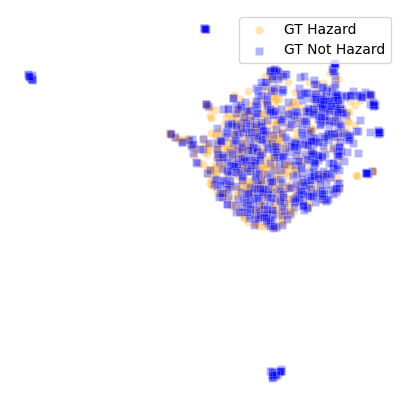

In [ ]:
GT_labels['umap_x'] = umap_gt_embed[:,0]
GT_labels['umap_y'] = umap_gt_embed[:,1]

#gpt['umap_x'] = umap_pseudo_embed[:,0]
#gpt['umap_y'] = umap_pseudo_embed[:,1]


fig,ax = plt.subplots(1,1,figsize=(5,5))

sns.scatterplot(data = GT_labels.loc[GT_labels['hazard']>=0.5],x='umap_x',y='umap_y',color='orange',alpha=0.3,marker='o',ax=ax,label='GT Hazard')
sns.scatterplot(data =GT_labels.loc[GT_labels['hazard']<0.5],x='umap_x',y='umap_y',color='blue',alpha=0.3,marker='s',ax=ax,label='GT Not Hazard')
plt.legend()
plt.axis('off')
plt.show()

#fig,ax = plt.subplots(1,1,figsize=(5,5))
#sns.scatterplot(data = gpt.loc[gpt['hazard']>=0.5],x='umap_x',y='umap_y',color='orange',alpha=0.6,s=13,marker='o',ax=ax,label='Pseduo-Label Hazard')
#sns.scatterplot(data =gpt.loc[gpt['hazard']<0.5],x='umap_x',y='umap_y',color='blue',alpha=0.1,s=13,marker='s',ax=ax,label='Pseduo-Label Not Hazard')

#plt.legend()
#plt.axis('off')
#plt.show()

## Training model

### hyperparameter tuning

In [ ]:
# GPT 3.5 & 4.0 as of April 14, 2023
gt_data = GT_labels.sample(frac=1)
gpt_file = 'gpt35_qualtrics-prompt_responses.csv'#'gpt35_alt-prompt_responses.csv'
gpt_labels = pd.read_csv(gpt_file)
print(len(gpt_labels))
gpt_texts = set(gpt_labels['text'].values.tolist())
response_gpt_labels = gpt_labels.groupby('text')
gpt_pred = []
for text in gt_data['old_text'].values:
    #text = GT_labels.loc[[(v==[embed]).all() for v in GT_labels['embeddings']],'old_text'].values[0]
    #if 'Ethiopian' in text:
    #  print(text)
    label = 0
    if text in gpt_texts:
        response = response_gpt_labels.get_group(text)['responses'].values[0]
        if 'Yes' in response[:4]:
            label = 1

        elif 'No' in response[:4]:
            label = 0
    else:
      print('error')
    gpt_pred.append(label)
gt_data['gpt_pred'] = gpt_pred

gpt_file = 'gpt4_responses.csv'
gpt_labels = pd.read_csv(gpt_file)
print(len(gpt_labels))
gpt_texts = set(gpt_labels['text'].values.tolist())
response_gpt_labels = gpt_labels.groupby('text')

gpt_pred = []
for text in gt_data['old_text'].values:
    #text = GT_labels.loc[[(v==[embed]).all() for v in GT_labels['embeddings']],'old_text'].values[0]
    #if 'Ethiopian' in text:
    #  print(text)
    label = 0
    if text in gpt_texts:
        response = response_gpt_labels.get_group(text)['responses'].values[0]
        if 'Yes' in response[:4]:
            label = 1

        elif 'No' in response[:4]:
            label = 0
    else:
      print('error')
    gpt_pred.append(label)
gt_data['gpt4_pred'] = gpt_pred

gpt_file = 'gpt35_cons_qualtrics-prompt_responses.csv'
gpt_labels = pd.read_csv(gpt_file)
print(len(gpt_labels))
gpt_texts = set(gpt_labels['text'].values.tolist())
response_gpt_labels = gpt_labels.groupby('text')
gpt_pred = []
for text in gt_data['old_text'].values:
    #text = GT_labels.loc[[(v==[embed]).all() for v in GT_labels['embeddings']],'old_text'].values[0]
    #if 'Ethiopian' in text:
    #  print(text)
    label = 0
    if text in gpt_texts:
        response = response_gpt_labels.get_group(text)['responses'].values[0]
        if 'Yes' in response[:4]:
            label = 1

        elif 'No' in response[:4]:
            label = 0
    else:
      print('error')
    gpt_pred.append(label)
gt_data['gpt_soc_pred'] = gpt_pred

gpt_file = 'gpt35_lib_qualtrics-prompt_responses.csv'
gpt_labels = pd.read_csv(gpt_file)
print(len(gpt_labels))
gpt_texts = set(gpt_labels['text'].values.tolist())
response_gpt_labels = gpt_labels.groupby('text')
gpt_pred = []
for text in gt_data['old_text'].values:
    #text = GT_labels.loc[[(v==[embed]).all() for v in GT_labels['embeddings']],'old_text'].values[0]
    #if 'Ethiopian' in text:
    #  print(text)
    label = 0
    if text in gpt_texts:
        response = response_gpt_labels.get_group(text)['responses'].values[0]
        if 'Yes' in response[:4]:
            label = 1

        elif 'No' in response[:4]:
            label = 0
    else:
      print('error')
    gpt_pred.append(label)
gt_data['gpt_lib_pred'] = gpt_pred

gt_xy =gt_data[['embeddings','hazard','gpt_pred','gpt_soc_pred','gpt4_pred','gpt_lib_pred']].replace([None],np.nan).dropna()

#pseudo_label_data = gpt.sample(frac=1)[['embeddings','hazard']].replace([None],np.nan).dropna()
X = np.array([v.astype('float32') for v in gt_xy['embeddings'].values])
y = np.array([[round(l),gp,gps,gpt4,gptl] for l,gp,gps,gpt4,gptl in gt_xy[['hazard','gpt_pred','gpt_soc_pred','gpt4_pred','gpt_lib_pred']].values])

#X_pseudo = np.array([e.astype('float32') for e in pseudo_label_data['embeddings'].values])
#y_pseudo = np.array([round(l) for l in pseudo_label_data['hazard'].values])



1338
1338
1338
1338


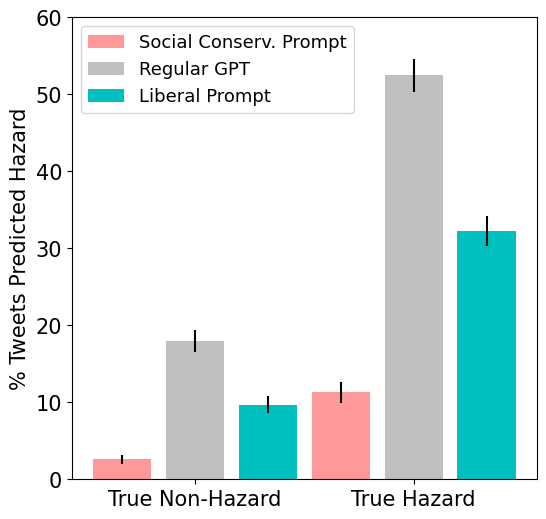

[0.0, 0.0]


In [ ]:

matplotlib.rcParams.update({'font.size': 15})
labelfonts = {'fontname':'Arial','fontsize':15}
#num_agree = np.array(gpt_soc_labels['gpt_pred'].values==gpt_labels['gpt_pred'].values).astype(int).mean()
#tot_num = len(gpt_soc_labels)

#print(num_agree/tot_num)
#num_agree = np.array(gpt_soc_labels['text'].values==gpt_labels['text'].values).astype(int).mean()
#print(num_agree/tot_num)
#print(pd.merge(gpt_labels,gpt_soc_labels,on='text')[['gpt_pred','gpt_soc_pred']])
#preds = pd.merge(gpt_labels,gpt_soc_labels,on='text')

#print((preds['gpt_pred']==preds['gpt_soc_pred']).values.astype(int).mean())

fig,ax = plt.subplots(1,1,figsize=(6,6))

not_hazard = gt_data.loc[gt_data['hazard']<0.5,'gpt_soc_pred'].values.mean()
not_hazard_error = gt_data.loc[gt_data['hazard']<0.5,'gpt_soc_pred'].values.std()/np.sqrt(len(gt_data.loc[gt_data['hazard']<0.5]))

hazard = gt_data.loc[gt_data['hazard']>=0.5,'gpt_soc_pred'].values.mean()
hazard_error = gt_data.loc[gt_data['hazard']>=0.5,'gpt_soc_pred'].values.std()/np.sqrt(len(gt_data.loc[gt_data['hazard']>=0.5]))

plt.bar([0,3],[not_hazard*100,hazard*100],label='Social Conserv. Prompt',color='r',alpha=0.4)
plt.errorbar([0,3],[not_hazard*100,hazard*100],yerr=[not_hazard_error*100,hazard_error*100],color='k',linestyle='')



not_hazard = gt_data.loc[gt_data['hazard']<0.5,'gpt_pred'].values.mean()
not_hazard_error = gt_data.loc[gt_data['hazard']<0.5,'gpt_pred'].values.std()/np.sqrt(len(gt_data.loc[gt_data['hazard']<0.5]))
hazard = gt_data.loc[gt_data['hazard']>=0.5,'gpt_pred'].values.mean()
hazard_error = gt_data.loc[gt_data['hazard']>=0.5,'gpt_pred'].values.std()/np.sqrt(len(gt_data.loc[gt_data['hazard']>=0.5]))
plt.bar([1,4],[not_hazard*100,hazard*100],label='Regular GPT',color='gray',alpha=0.5)
plt.errorbar([1,4],[not_hazard*100,hazard*100],yerr=[not_hazard_error*100,hazard_error*100],color='k',linestyle='')

not_hazard = gt_data.loc[gt_data['hazard']<0.5,'gpt_lib_pred'].values.mean()
not_hazard_error = gt_data.loc[gt_data['hazard']<0.5,'gpt_lib_pred'].values.std()/np.sqrt(len(gt_data.loc[gt_data['hazard']<0.5]))
hazard = gt_data.loc[gt_data['hazard']>=0.5,'gpt_lib_pred'].values.mean()
hazard_error = gt_data.loc[gt_data['hazard']>=0.5,'gpt_lib_pred'].values.std()/np.sqrt(len(gt_data.loc[gt_data['hazard']>=0.5]))
plt.bar([2,5],[not_hazard*100,hazard*100],label='Liberal Prompt',color='c',alpha=1)
plt.errorbar([2,5],[not_hazard*100,hazard*100],yerr=[not_hazard_error*100,hazard_error*100],color='k',linestyle='')


plt.legend(fontsize=13,loc='upper left')
plt.xticks([1,4],['True Non-Hazard','True Hazard'],**labelfonts)
plt.ylabel('% Tweets Predicted Hazard',**labelfonts)
plt.ylim([0,60])
plt.show()


ttest_non_hazard = ttest_ind(gt_data.loc[gt_data['hazard']<0.5,'gpt_soc_pred'].values,gt_data.loc[gt_data['hazard']<0.5,'gpt_pred'].values)

ttest_hazard = ttest_ind(gt_data.loc[gt_data['hazard']>=0.5,'gpt_soc_pred'].values,gt_data.loc[gt_data['hazard']>=0.5,'gpt_pred'].values)
print([round(ttest_non_hazard.pvalue,4),round(ttest_hazard.pvalue,4)])

In [ ]:

# Reset index
# Model #Avoid overfitting using dropout layers, batch normalization, feature normalization, regularization, and leaky relu/elu
embedding_dim = 768

metrics = {'NN_auc':[],'NN_f1':[],'RF_auc':[],'RF_f1':[],'SVM_auc':[],'SVM_f1':[],'XGB_auc':[],'XGB_f1':[],'gpt_auc':[],'gpt_f1':[],'base_f1':[]}
metrics = {'gpt_auc':[],'gpt_f1':[],'gpt_soc_auc':[],'gpt_soc_f1':[],'gpt_lib_auc':[],'gpt_lib_f1':[],'gpt4_auc':[],'gpt4_f1':[]}
for ii in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.9, random_state=ii)
    y_train = y_train[:,0].round()
    gpt_p = y_test[:,1]
    gpt_s_p = y_test[:,2]
    gpt4_p = y_test[:,3]
    gptl_p = y_test[:,4]
    y_test = y_test[:,0].round()
    auc = roc_auc_score(y_test, gpt_p)
    f1=f1_score(y_test, gpt_p)
    metrics['gpt_auc'].append(auc)
    metrics['gpt_f1'].append(f1)
    auc = roc_auc_score(y_test, gpt_s_p)
    f1=f1_score(y_test, gpt_s_p)
    metrics['gpt_soc_auc'].append(auc)
    metrics['gpt_soc_f1'].append(f1)
    auc = roc_auc_score(y_test, gpt4_p)
    f1=f1_score(y_test, gpt4_p)
    metrics['gpt4_auc'].append(auc)
    metrics['gpt4_f1'].append(f1)
    auc = roc_auc_score(y_test, gptl_p)
    f1=f1_score(y_test, gptl_p)
    metrics['gpt_lib_auc'].append(auc)
    metrics['gpt_lib_f1'].append(f1)
    if False:

      embedding_normalizer = Normalization(input_shape=[embedding_dim,], axis=None)
      embedding_normalizer.adapt(X_train)
      def modeling(l2_lambda=0.001, relu_alpha=0.1, dropout_rate=0.7):
          model = Sequential([
          embedding_normalizer,
          Dense(int(embedding_dim/3),kernel_regularizer=regularizers.l2(l2_lambda)),
          LeakyReLU(relu_alpha), #alpha=negative coefficient for the slope
          BatchNormalization(),
          Dropout(dropout_rate),
          Dense(int(embedding_dim/9), kernel_regularizer=regularizers.l2(l2_lambda)),
          LeakyReLU(relu_alpha),
          BatchNormalization(),
          Dropout(dropout_rate),
          Dense(int(embedding_dim/27),kernel_regularizer=regularizers.l2(l2_lambda)),
          LeakyReLU(relu_alpha),
          BatchNormalization(),
          Dropout(dropout_rate),
          #Dense(int(embedding_dim/16),kernel_regularizer=regularizers.l2(l2_lambda)),
          #LeakyReLU(relu_alpha),
          #BatchNormalization(),
          #Dropout(dropout_rate),
          Dense(1, activation=tf.keras.activations.sigmoid)
          ])
          model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['binary_crossentropy',AUC()])
          return model

      es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5) #min_delta=1 #baseline=26


      m = modeling()
      #history = m.fit(X_pseudo, y_pseudo, validation_split=0.1, epochs=100, batch_size=32, verbose=2,callbacks=[es]) #callbacks=[es])

      history = m.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=32, verbose=2,callbacks=[es]) #callbacks=[es])
      y_pred = m.predict(X_test)
      metrics['NN_auc'].append(roc_auc_score(y_test, y_pred))
      metrics['NN_f1'].append(f1_score(y_test,y_pred.round()))
      #,'RF_auc':[],'RF_f1':[],'SVM_auc':[],'SVM_f1':[],'XGB_auc':[],'XGB_f1':[]}
      clf = RandomForestClassifier(max_depth=10, random_state=42)
      clf.fit(X_train, y_train)

      pred_prob = clf.predict_proba(X_test)[:,1]
      pred = clf.predict(X_test)
      auc = roc_auc_score(y_test, pred_prob)
      f1=f1_score(y_test, pred)
      metrics['RF_auc'].append(auc)
      metrics['RF_f1'].append(f1)
      clf = SVC(probability=True)
      clf.fit(X_train, y_train)

      pred_prob = clf.predict_proba(X_test)[:,1]
      pred = clf.predict(X_test)
      auc = roc_auc_score(y_test, pred_prob)
      f1=f1_score(y_test, pred)
      metrics['SVM_auc'].append(auc)
      metrics['SVM_f1'].append(f1)

      clf = XGBClassifier()
      clf.fit(X_train, y_train)

      pred_prob = clf.predict_proba(X_test)[:,1]
      auc = roc_auc_score(y_test, pred_prob)

      pred = clf.predict(X_test)
      f1=f1_score(y_test, pred)
      metrics['XGB_auc'].append(auc)
      metrics['XGB_f1'].append(f1)





      print([auc,f1])

      f1_base=f1_score(y_test,[1]*len(y_test))
      metrics['base_f1'].append(f1_base)

pd.DataFrame(metrics).to_csv('metrics_gpt_vs_gpt_s.csv',index=False)

#pd.DataFrame(metrics).to_csv('metrics_gpt.csv',index=False)

In [ ]:
metrics = pd.read_csv('metrics_gpt_vs_gpt_s.csv')

for col in metrics.columns:
  if 'auc' in col:
      print([col,round(metrics[col].values.mean(),3),round(metrics[col].values.std(),3)])

for col in metrics.columns:
  if 'f1' in col:
      print([col,round(metrics[col].values.mean(),3),round(metrics[col].values.std(),3)])


['gpt_auc', 0.671, 0.038]
['gpt_soc_auc', 0.539, 0.025]
['gpt_lib_auc', 0.625, 0.041]
['gpt4_auc', 0.677, 0.042]
['gpt_f1', 0.544, 0.056]
['gpt_soc_f1', 0.19, 0.071]
['gpt_lib_f1', 0.447, 0.075]
['gpt4_f1', 0.555, 0.061]


In [ ]:
metrics = pd.read_csv('metrics.csv')

for col in metrics.columns:
  if 'auc' in col:
      print([col,round(metrics[col].values.mean(),3),round(metrics[col].values.std(),3)])

for col in metrics.columns:
  if 'f1' in col:
      print([col,round(metrics[col].values.mean(),3),round(metrics[col].values.std(),3)])


['NN_auc', 0.723, 0.047]
['RF_auc', 0.73, 0.045]
['SVM_auc', 0.737, 0.045]
['XGB_auc', 0.723, 0.043]
['NN_f1', 0.453, 0.077]
['RF_f1', 0.214, 0.078]
['SVM_f1', 0.409, 0.069]
['XGB_f1', 0.434, 0.077]
['base_f1', 0.482, 0.042]


In [ ]:
metrics = pd.read_csv('metrics_gpt.csv')

for col in metrics.columns:
  if 'auc' in col:
      print([col,round(metrics[col].values.mean(),3),round(metrics[col].values.std(),3)])

for col in metrics.columns:
  if 'f1' in col:
      print([col,round(metrics[col].values.mean(),3),round(metrics[col].values.std(),3)])


['NN_auc', 0.724, 0.04]
['RF_auc', 0.716, 0.04]
['SVM_auc', 0.719, 0.038]
['XGB_auc', 0.704, 0.039]
['gpt_auc', 0.679, 0.04]
['NN_f1', 0.411, 0.078]
['RF_f1', 0.212, 0.07]
['SVM_f1', 0.396, 0.064]
['XGB_f1', 0.408, 0.075]
['gpt_f1', 0.562, 0.056]
['base_f1', 0.477, 0.039]


GPT3.5_auc
GPT3.5-SocCons_auc
GPT3.5-LibCons_auc
GPT4_auc
{'GPT3.5_auc': [0.671, 0.038, 50], 'GPT3.5-SocCons_auc': [0.539, 0.025, 50], 'GPT3.5-LibCons_auc': [0.625, 0.041, 50], 'GPT4_auc': [0.677, 0.042, 50]}


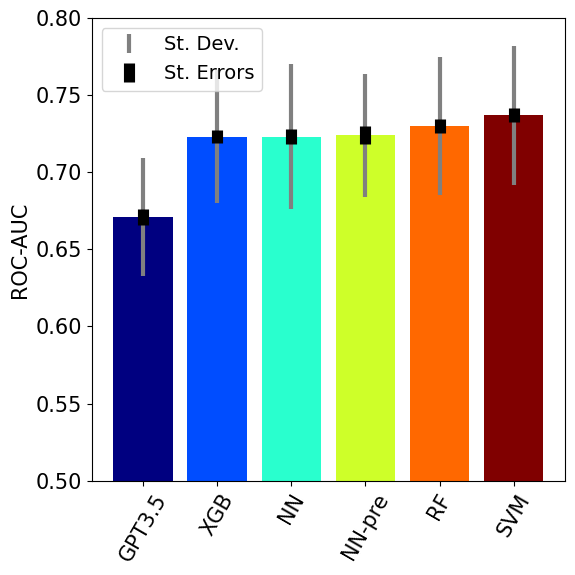

In [ ]:

matplotlib.rcParams.update({'font.size': 15})
labelfonts = {'fontname':'Arial','fontsize':15}
metrics = pd.read_csv('metrics_gpt_vs_gpt_s.csv')
aucs={}
for col in metrics.columns:
  if 'auc' in col:
      key = col.replace('gpt','GPT').replace('_soc','-SocCons').replace('_lib','-LibCons')
      if key=='GPT_auc':
        key='GPT3.5_auc'
      if 'Soc' in key:
        key = 'GPT3.5-SocCons_auc'
      if 'Lib' in key:
        key = 'GPT3.5-LibCons_auc'
      print(key)
      aucs[key]=[round(metrics[col].values.mean(),3),round(metrics[col].values.std(),3),len(metrics[col])]
print( aucs)
metrics = pd.read_csv('metrics.csv')
for col in metrics.columns:
  if 'auc' in col:
      aucs[col]=[round(metrics[col].values.mean(),3),round(metrics[col].values.std(),3),len(metrics[col])]
metrics = pd.read_csv('metrics_gpt.csv')
for col in metrics.columns:
  if 'NN_auc' in col:
      aucs['NN-pre_auc']=[round(metrics[col].values.mean(),3),round(metrics[col].values.std(),3),len(metrics[col])]
aucs = pd.DataFrame(aucs)
bars = [aucs[c][0] for c in ['GPT3.5_auc','XGB_auc','NN_auc','NN-pre_auc']+sorted(aucs.columns)[6:-1]]#'GPT3.5-SocCons_auc','GPT3.5-LibCons_auc','GPT4_auc',
stds = [aucs[c][1] for c in ['GPT3.5_auc','XGB_auc','NN_auc','NN-pre_auc']+sorted(aucs.columns)[6:-1]]

ax,fig = plt.subplots(1,1,figsize=(6,6))
errors = [aucs[c][1]/np.sqrt(aucs[c][2]) for c in ['GPT3.5_auc','XGB_auc','NN_auc','NN-pre_auc']+sorted(aucs.columns)[6:-1]]# 'GPT3.5-SocCons_auc','GPT3.5-LibCons_auc','GPT4_auc',
jet = plt.get_cmap('jet')
plt.bar(list(range(len(aucs.columns)))[:-3],bars,color=[jet(i/(len(aucs.columns)-1-3)) for i in range(len(aucs.columns))])
plt.errorbar(list(range(len(aucs.columns)))[:-3],bars,yerr=stds,color='gray',linestyle='',linewidth=3,label='St. Dev.')

plt.errorbar(list(range(len(aucs.columns)))[:-3],bars,yerr=errors,color='k',linewidth=8,alpha=1,linestyle='',label='St. Errors')
plt.xticks(list(range(len(aucs.columns)))[:-3],[c.split('_')[0] for c in ['GPT3.5_auc','XGB_auc','NN_auc','NN-pre_auc']+sorted(aucs.columns)[6:-1]],rotation=60)# 'GPT3.5-SocCons_auc','GPT3.5-LibCons_auc','GPT4_auc',
plt.ylabel('ROC-AUC')
plt.legend(fontsize=14,loc='upper left')
plt.ylim([0.5,0.8])
plt.tight_layout()
plt.savefig('AUC_comparisons.pdf')
plt.show()

In [ ]:
sorted(aucs)


['GPT3.5-LibCons_auc',
 'GPT3.5-SocCons_auc',
 'GPT3.5_auc',
 'GPT4_auc',
 'NN-pre_auc',
 'NN_auc',
 'RF_auc',
 'SVM_auc',
 'XGB_auc']

In [ ]:
import pickle as pk
gt_data = GT_labels.sample(frac=1)
gt_xy =gt_data[['embeddings','hazard']].replace([None],np.nan).dropna()
X = np.array([v.astype('float32') for v in gt_xy['embeddings'].values])
y = np.array([round(l) for l in gt_xy['hazard'].values])
clf = SVC(probability=True)
clf.fit(X, y)
filename = 'finalized_model_SVM.sav'
pk.dump(clf, open(filename, 'wb'))

clf = RandomForestClassifier(max_depth=10, random_state=42)
clf.fit(X, y)
filename = 'finalized_model_RF.sav'
pk.dump(clf, open(filename, 'wb'))


clf = XGBClassifier()
clf.fit(X, y)
filename = 'finalized_model_XGB.sav'
pk.dump(clf, open(filename, 'wb'))
#loaded_model = pickle.load(open(filename, 'rb'))



embedding_normalizer = Normalization(input_shape=[embedding_dim,], axis=None)
embedding_normalizer.adapt(X)
def modeling(l2_lambda=0.001, relu_alpha=0.1, dropout_rate=0.7):
    model = Sequential([
    embedding_normalizer,
    Dense(int(embedding_dim/3),kernel_regularizer=regularizers.l2(l2_lambda)),
    LeakyReLU(relu_alpha), #alpha=negative coefficient for the slope
    BatchNormalization(),
    Dropout(dropout_rate),
    Dense(int(embedding_dim/9), kernel_regularizer=regularizers.l2(l2_lambda)),
    LeakyReLU(relu_alpha),
    BatchNormalization(),
    Dropout(dropout_rate),
    Dense(int(embedding_dim/27),kernel_regularizer=regularizers.l2(l2_lambda)),
    LeakyReLU(relu_alpha),
    BatchNormalization(),
    Dropout(dropout_rate),
    #Dense(int(embedding_dim/16),kernel_regularizer=regularizers.l2(l2_lambda)),
    #LeakyReLU(relu_alpha),
    #BatchNormalization(),
    #Dropout(dropout_rate),
    Dense(1, activation=tf.keras.activations.sigmoid)
    ])
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['binary_crossentropy',AUC()])
    return model

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5) #min_delta=1 #baseline=26


m = modeling()

history = m.fit(X, y, validation_split=0.1, epochs=100, batch_size=32, verbose=2,callbacks=[es]) #callbacks=[es])

#m.save('finalized_model_NN.sav')




NameError: ignored

In [ ]:
# baselines

X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.9, random_state=10)

clf = SVC(probability=True)
clf.fit(X_train, y_train)

preds = clf.predict_proba(X_test)[:,1]
conf=np.arange(0,1.1,0.1)
mean_conf = (conf[:-1]+conf[1:])/2
print(mean_conf)
neg_cases = [len(y_test[(preds>c1) & (preds<=c2)]) - np.sum(y_test[(preds>c1) & (preds<=c2)]) for c1,c2 in zip(conf[:-1],conf[1:])]
pos_cases = [np.sum(y_test[(preds>c1) & (preds<=c2)]) for c1,c2 in zip(conf[:-1],conf[1:])]

interval = []
expectation = []
confidence=0.95
for a,b in zip(pos_cases,neg_cases):
    interval.append(beta.interval(confidence, a+1, b+1)) # add 1 for uniformprior
    expectation.append(a/(a+b))
interval = np.array(interval)
plt.subplots(1,1,figsize=(6,6))
plt.plot(mean_conf,expectation,'sr-')
plt.plot([0,1],[0,1],'k--')
plt.fill_between(mean_conf,interval[:,1],interval[:,0],color='r',alpha=0.1)
plt.xlabel('Confidence')
plt.ylabel('Fraction positive')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

NameError: ignored

In [ ]:
data = pd.read_csv('urbanlegend_dataset_CODER#S.csv')
data.columns = ['number','hazard','hazard_aspect','hazard_central','hazard_severe','hazard_overcome','benefit','benefit_aspect','benefit_central','benefit_severe','benefit_obtain','coder']
cleaned_data = data[['number','hazard','hazard_severe','benefit','benefit_severe']].replace('Y',1).replace('N',0).replace('S',1).replace('M',0)
cleaned_data['hazard_severe'] = cleaned_data['hazard_severe'].fillna(0)
cleaned_data['benefit_severe'] = cleaned_data['benefit_severe'].fillna(0)
cleaned_data = cleaned_data.dropna()
labeled_data = pd.read_excel('Urban Legend Data_ 2022 Snopes, Encyclopedia & 2014.xlsx',sheet_name='2014 Data')
#labeled_data = pd.read_csv('2014_labeled_data.csv')
titles = labeled_data['Title'].drop_duplicates()

title2num = {t:ii+1 for ii,t in enumerate(titles)}
number=[title2num[t] for t in labeled_data['Title'].values]
labeled_data['number']= number
num_cleaned_data = cleaned_data.groupby('number')
mean_hazard = {}
for number in cleaned_data['number'].drop_duplicates():
  h= cleaned_data.loc[cleaned_data['number']==number,'hazard'].values.mean()
  mean_hazard[number] = h

hazard_label = []
for n,line in labeled_data.iterrows():
  hazard_label.append(mean_hazard[line['number']])
labeled_data['hazard'] = np.array(hazard_label).round()
labeled_data['mean_hazard'] = np.array(hazard_label)
labeled_data=pd.merge(left=pd.read_csv('2014_labeled_data.csv')[['Example','summary']],right=labeled_data,on='Example')

In [ ]:
embedding_dim = 768
#loaded_model = pk.load(open(filename, 'rb'))
embed_model = SentenceTransformer('stsb-xlm-r-multilingual')#'all-mpnet-base-v2')
#labeled_data['']
embeddings = embed_model.encode(labeled_data['summary'].values.astype(str))
from tensorflow import keras

#filename = 'finalized_model.sav'
#loaded_model = pk.load(open(filename, 'rb'))

X = embeddings
y = labeled_data['hazard'].values
num = labeled_data['number'].values
metrics = {'SVM_pre_f1':[],'SVM_pre_auc':[],'SVM_f1':[],'SVM_auc':[],'RF_pre_f1':[],'RF_pre_auc':[],'RF_f1':[],'RF_auc':[],'XGB_pre_f1':[],'XGB_pre_auc':[],'XGB_f1':[],'XGB_auc':[],'NN_pre_f1':[],'NN_pre_auc':[],'NN_f1':[],'NN_auc':[],'base_f1':[]}
for i in range(50):


  num_list = list(np.unique(num))
  random.shuffle(num_list)
  train_ind = np.where(np.in1d(num, num_list[:190]))[0]
  test_ind = np.where(np.in1d(num, num_list[190:]))[0]
  #print(set(list(test_ind)).intersection(set(list(train_ind))))
  # 80% training, 20% testing
  X_train = X[train_ind]
  y_train = y[train_ind].round()
  X_test = X[test_ind]
  y_test = y[test_ind].round()

  filename = 'finalized_model_SVM.sav'
  loaded_model = pk.load(open(filename, 'rb'))
  f1 = f1_score(y_test,loaded_model.predict(X_test))
  auc = roc_auc_score(y_test,loaded_model.predict_proba(X_test)[:,1])
  metrics['SVM_pre_f1'].append(f1)
  metrics['SVM_pre_auc'].append(auc)
  loaded_model.fit(X_train,y_train)
  new_preds = loaded_model.predict_proba(X_test)[:,1]
  f1 = f1_score(y_test,new_preds.round())
  auc = roc_auc_score(y_test,new_preds)
  print(auc)
  metrics['SVM_f1'].append(f1)
  metrics['SVM_auc'].append(auc)

  filename = 'finalized_model_RF.sav'
  loaded_model = pk.load(open(filename, 'rb'))
  f1 = f1_score(y_test,loaded_model.predict(X_test))
  auc = roc_auc_score(y_test,loaded_model.predict_proba(X_test)[:,1])
  metrics['RF_pre_f1'].append(f1)
  metrics['RF_pre_auc'].append(auc)
  loaded_model.fit(X_train,y_train)
  new_preds = loaded_model.predict_proba(X_test)[:,1]
  f1 = f1_score(y_test,new_preds.round())
  auc = roc_auc_score(y_test.round(),new_preds)
  print(auc)
  metrics['RF_f1'].append(f1)
  metrics['RF_auc'].append(auc)

  filename = 'finalized_model_XGB.sav'
  loaded_model = pk.load(open(filename, 'rb'))
  f1 = f1_score(y_test,loaded_model.predict(X_test))
  auc = roc_auc_score(y_test,loaded_model.predict_proba(X_test)[:,1])
  metrics['XGB_pre_f1'].append(f1)
  metrics['XGB_pre_auc'].append(auc)
  loaded_model.fit(X_train,y_train)
  new_preds = loaded_model.predict_proba(X_test)[:,1]
  f1 = f1_score(y_test,new_preds.round())
  auc = roc_auc_score(y_test,new_preds)
  print(auc)
  metrics['XGB_f1'].append(f1)
  metrics['XGB_auc'].append(auc)

  loaded_model = keras.models.load_model('finalized_model_NN.sav')
  embedding_normalizer = Normalization(input_shape=[embedding_dim,], axis=None)
  embedding_normalizer.adapt(X_train)
  def modeling(l2_lambda=0.001, relu_alpha=0.1, dropout_rate=0.7):
      model = Sequential([
      embedding_normalizer,
      Dense(int(embedding_dim/3),kernel_regularizer=regularizers.l2(l2_lambda)),
      LeakyReLU(relu_alpha), #alpha=negative coefficient for the slope
      BatchNormalization(),
      Dropout(dropout_rate),
      Dense(int(embedding_dim/9), kernel_regularizer=regularizers.l2(l2_lambda)),
      LeakyReLU(relu_alpha),
      BatchNormalization(),
      Dropout(dropout_rate),
      Dense(int(embedding_dim/27),kernel_regularizer=regularizers.l2(l2_lambda)),
      LeakyReLU(relu_alpha),
      BatchNormalization(),
      Dropout(dropout_rate),
      #Dense(int(embedding_dim/16),kernel_regularizer=regularizers.l2(l2_lambda)),
      #LeakyReLU(relu_alpha),
      #BatchNormalization(),
      #Dropout(dropout_rate),
      Dense(1, activation=tf.keras.activations.sigmoid)
      ])
      model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['binary_crossentropy',AUC()])
      return model

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5) #min_delta=1 #baseline=26
  y_pred = loaded_model.predict(X_test)
  metrics['NN_pre_auc'].append(roc_auc_score(y_test, y_pred))
  metrics['NN_pre_f1'].append(f1_score(y_test,y_pred.round()))
  history = loaded_model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=32, verbose=2,callbacks=[es]) #callbacks=[es])
  y_pred = loaded_model.predict(X_test)
  metrics['NN_auc'].append(roc_auc_score(y_test, y_pred))
  metrics['NN_f1'].append(f1_score(y_test,y_pred.round()))

  f1_base=f1_score(y_test,[1]*len(y_test))
  metrics['base_f1'].append(f1_base)

pd.DataFrame(metrics).to_csv('UL_metrics.csv',index=False)


embedding_dim = 768
#loaded_model = pk.load(open(filename, 'rb'))
embed_model = SentenceTransformer('stsb-xlm-r-multilingual')#'all-mpnet-base-v2')
#labeled_data['']
embeddings = embed_model.encode(labeled_data['summary'].values.astype(str))
from tensorflow import keras

#embed_model = SentenceTransformer('all-mpnet-base-v2')
#labeled_data['']
#embeddings = embed_model.encode(labeled_data['Claim'].values.astype(str))
X = embeddings
y = labeled_data['hazard'].values.round()

model = keras.models.load_model('finalized_model_NN.sav')
embedding_normalizer = Normalization(input_shape=[embedding_dim,], axis=None)
embedding_normalizer.adapt(X)
def modeling(l2_lambda=0.001, relu_alpha=0.1, dropout_rate=0.7):
    model = Sequential([
    embedding_normalizer,
    Dense(int(embedding_dim/3),kernel_regularizer=regularizers.l2(l2_lambda)),
    LeakyReLU(relu_alpha), #alpha=negative coefficient for the slope
    BatchNormalization(),
    Dropout(dropout_rate),
    Dense(int(embedding_dim/9), kernel_regularizer=regularizers.l2(l2_lambda)),
    LeakyReLU(relu_alpha),
    BatchNormalization(),
    Dropout(dropout_rate),
    Dense(int(embedding_dim/27),kernel_regularizer=regularizers.l2(l2_lambda)),
    LeakyReLU(relu_alpha),
    BatchNormalization(),
    Dropout(dropout_rate),
    #Dense(int(embedding_dim/16),kernel_regularizer=regularizers.l2(l2_lambda)),
    #LeakyReLU(relu_alpha),
    #BatchNormalization(),
    #Dropout(dropout_rate),
    Dense(1, activation=tf.keras.activations.sigmoid)
    ])
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['binary_crossentropy',AUC()])
    return model

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5) #min_delta=1 #baseline=26
history = model.fit(X, y, validation_split=0.1, epochs=100, batch_size=32, verbose=2,callbacks=[es]) #callbacks=[es])


model.save('finalized_model_NN_UL.sav')




In [ ]:
clf = pk.load(open('finalized_model_SVM.sav','rb'))#SVC(probability=True)
clf.fit(X, y)
filename = 'finalized_model_SVM_UL.sav'
pk.dump(clf, open(filename, 'wb'))

labeled_data['summary_embedding'] = [e for e in X]
labeled_data.to_csv('Cleaned_2014_data.csv',index=False)

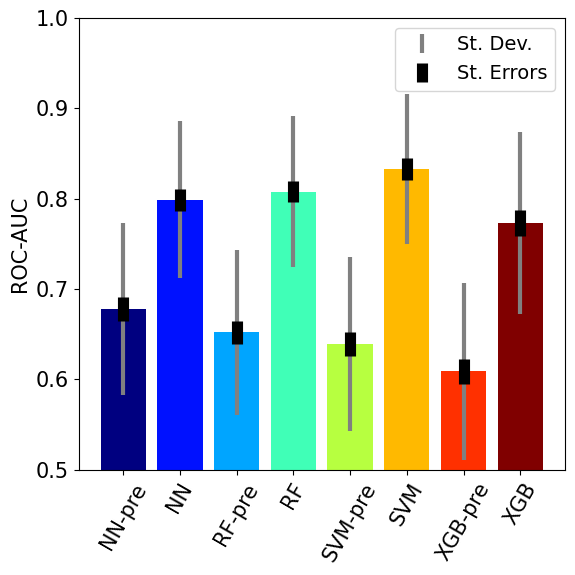

In [ ]:

matplotlib.rcParams.update({'font.size': 15})
labelfonts = {'fontname':'Arial','fontsize':15}
metrics = pd.read_csv('UL_metrics.csv')
aucs = {}
for col in metrics.columns:
  if 'auc' in col:
      key = col.replace('_pre','-pre')
      aucs[key]=[round(metrics[col].values.mean(),3),round(metrics[col].values.std(),3),len(metrics[col])]
aucs = pd.DataFrame(aucs)
bars = [aucs[c][0] for c in sorted(aucs.columns)]
stds = [aucs[c][1] for c in sorted(aucs.columns)]

ax,fig = plt.subplots(1,1,figsize=(6,6))
errors = [aucs[c][1]/np.sqrt(aucs[c][2]) for c in sorted(aucs.columns)]
jet = plt.get_cmap('jet')
plt.bar(list(range(len(aucs.columns))),bars,color=[jet(i/(len(aucs.columns)-1)) for i in range(len(aucs.columns))])
plt.errorbar(list(range(len(aucs.columns))),bars,yerr=stds,color='gray',linestyle='',linewidth=3,label='St. Dev.')

plt.errorbar(list(range(len(aucs.columns))),bars,yerr=errors,color='k',linewidth=8,alpha=1,linestyle='',label='St. Errors')
plt.xticks(list(range(len(aucs.columns))),[c.split('_')[0] for c in sorted(aucs.columns)],rotation=60)
plt.ylabel('ROC-AUC')
plt.legend(fontsize=14,loc='upper right')
plt.ylim([0.5,1.0])
plt.tight_layout()
plt.savefig('AUC_UL.pdf',transparent=True)
plt.show()

In [ ]:
# applying NN to understand hazards in ULs
filename = 'finalized_model_SVM_UL.sav'
model = SentenceTransformer('stsb-xlm-r-multilingual')#'all-mpnet-base-v2')#'all-MiniLM-L6-v2')

clf = pk.load(open(filename,'rb'))#SVC(probability=True)
unlabeled_data_SNOPES = pd.read_excel('Urban Legend Data_ 2022 Snopes, Encyclopedia & 2014.xlsx',sheet_name='992 SNOPES LEGENDS')

unlabeled_data_SNOPES = pd.merge(unlabeled_data_SNOPES,pd.read_csv('unlabeled_SNOPES.csv'),on='LEGEND TEXT ')
unlabeled_data_SNOPES['summary_embedding'] = [e for e in model.encode(unlabeled_data_SNOPES['summary'].values)]
#unlabeled_data_SNOPES['hazard_pred'] = clf.predict_proba([u for u in unlabeled_data_SNOPES['summary_embedding'].values])

unlabeled_data_SNOPES['hazard_pred'] = [clf.predict_proba([u])[0,1] for u in unlabeled_data_SNOPES['summary_embedding'].values]
unlabeled_data_Enc = pd.read_excel('Urban Legend Data_ 2022 Snopes, Encyclopedia & 2014.xlsx',sheet_name='255 Encyclopedia Of Urban Legen')
unlabeled_data_Enc = unlabeled_data_Enc[['NARRATIVE MYTH/Legend Title ','LEGEND TEXT ']]
unlabeled_data_Enc = pd.merge(unlabeled_data_Enc,pd.read_csv('unlabeled_Enc.csv'),on=['LEGEND TEXT ','NARRATIVE MYTH/Legend Title '])
unlabeled_data_Enc.columns = ['title','text','summary']

#unlabeled_data_Enc['summary_embedding'] = model.encode(unlabeled_data_Enc['summary'].values)
unlabeled_data_Enc['summary_embedding'] = [e for e in model.encode(unlabeled_data_Enc['summary'].values)]
#unlabeled_data_Enc['hazard_pred'] = clf.predict_proba(unlabeled_data_Enc['summary_embedding'].values)
unlabeled_data_Enc['hazard_pred'] = [clf.predict_proba([u])[0,1] for u in unlabeled_data_Enc['summary_embedding'].values]

unlabeled_data_SNOPES.to_csv('unlabeled_data_SNOPES.csv',index=False)
unlabeled_data_Enc.to_csv('unlabeled_data_Enc.csv',index=False)


In [ ]:
embed_model = SentenceTransformer('stsb-xlm-r-multilingual')#'all-mpnet-base-v2')
embeddings = embed_model.encode(labeled_data['summary'].values.astype(str))
X = embeddings
y = labeled_data['hazard'].values.round()

#labeled_data[['summary','hazard']]
fit = umap.UMAP()
all_embeddings = np.concatenate([X,np.array([e for e in unlabeled_data_Enc['summary_embedding'].values]),np.array([e for e in unlabeled_data_SNOPES['summary_embedding'].values])])

trans = fit.fit(all_embeddings)


umap_embed = trans.transform(X)
labeled_data['umap_x']=umap_embed[:,0]
labeled_data['umap_y']=umap_embed[:,1]


umap_embed = trans.transform(np.array([e for e in unlabeled_data_SNOPES['summary_embedding'].values]))
unlabeled_data_SNOPES['umap_x']=umap_embed[:,0]
unlabeled_data_SNOPES['umap_y']=umap_embed[:,1]


umap_embed = trans.transform(np.array([e for e in unlabeled_data_Enc['summary_embedding'].values]))
unlabeled_data_Enc['umap_x']=umap_embed[:,0]
unlabeled_data_Enc['umap_y']=umap_embed[:,1]

unlabeled_data_SNOPES.to_csv('unlabeled_data_SNOPES.csv',index=False)
unlabeled_data_Enc.to_csv('unlabeled_data_Enc.csv',index=False)
labeled_data.to_csv('Cleaned_2014_data.csv',index=False)

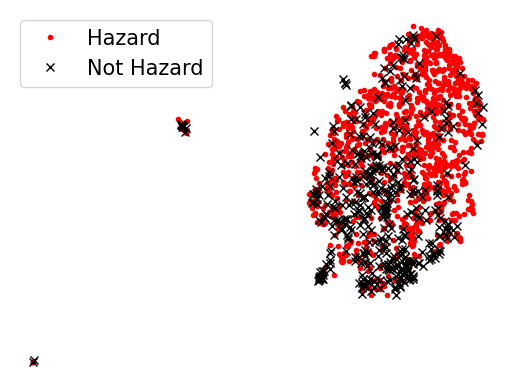

In [ ]:
#all_embeddings = np.concatenate([X,unlabeled_data_Enc['summary_embedding'].values,unlabeled_data_SNOPES['summary_embedding'].values],axis=1)

matplotlib.rcParams.update({'font.size': 15})
labelfonts = {'fontname':'Arial','fontsize':15}

all_umap_x_hazard = pd.concat([labeled_data.loc[labeled_data['hazard']>0.5,'umap_x'],unlabeled_data_SNOPES.loc[unlabeled_data_SNOPES['hazard_pred']>0.5,'umap_x'],unlabeled_data_Enc.loc[unlabeled_data_Enc['hazard_pred']>0.5,'umap_x']])
all_umap_y_hazard = pd.concat([labeled_data.loc[labeled_data['hazard']>0.5,'umap_y'],unlabeled_data_SNOPES.loc[unlabeled_data_SNOPES['hazard_pred']>0.5,'umap_y'],unlabeled_data_Enc.loc[unlabeled_data_Enc['hazard_pred']>0.5,'umap_y']])
all_umap_x_nohazard = pd.concat([labeled_data.loc[labeled_data['hazard']<0.5,'umap_x'],unlabeled_data_SNOPES.loc[unlabeled_data_SNOPES['hazard_pred']<0.5,'umap_x'],unlabeled_data_Enc.loc[unlabeled_data_Enc['hazard_pred']<0.5,'umap_x']])
all_umap_y_nohazard = pd.concat([labeled_data.loc[labeled_data['hazard']<0.5,'umap_y'],unlabeled_data_SNOPES.loc[unlabeled_data_SNOPES['hazard_pred']<0.5,'umap_y'],unlabeled_data_Enc.loc[unlabeled_data_Enc['hazard_pred']<0.5,'umap_y']])
plt.plot(all_umap_x_hazard,all_umap_y_hazard,'r.',label='Hazard')
plt.plot(all_umap_x_nohazard,all_umap_y_nohazard,'kx',label='Not Hazard')
plt.legend()
plt.axis('off')
plt.show()



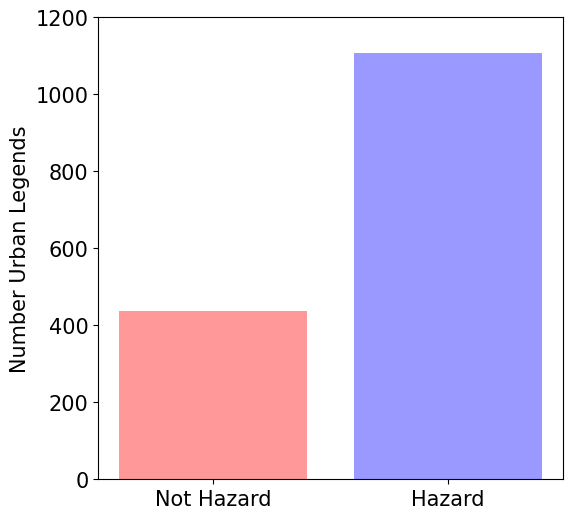

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
plt.bar([0,1],[len(all_umap_x_nohazard),len(all_umap_x_hazard)],color=['r','b'],alpha=0.4)
plt.ylabel('Number Urban Legends')
plt.xticks([0,1],['Not Hazard','Hazard'])
plt.ylim([0,1200])
plt.show()

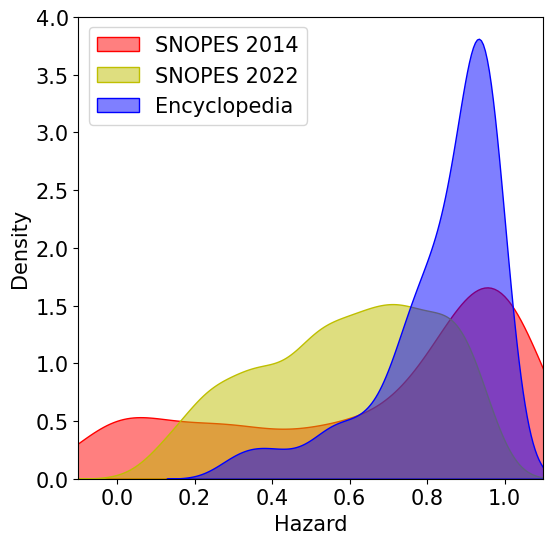

In [ ]:
#unlabeled_data_SNOPES['hazard_pred']
matplotlib.rcParams.update({'font.size': 15})
labelfonts = {'fontname':'Arial','fontsize':15}
#for n,line in labeled_data.iterrows():
#  hazard_label.append(mean_hazard[line['number']])
unlabeled_data_SNOPES = pd.read_csv('unlabeled_data_SNOPES.csv')
unlabeled_data_Enc= pd.read_csv('unlabeled_data_Enc.csv')
fig,ax=plt.subplots(1,1,figsize=(6,6))
sns.kdeplot(labeled_data['mean_hazard'],color='r',fill=True,alpha=0.5,label='SNOPES 2014')
sns.kdeplot(unlabeled_data_SNOPES['hazard_pred'],color='y',fill=True,alpha=0.5,label='SNOPES 2022')
sns.kdeplot(unlabeled_data_Enc['hazard_pred'],color='b',fill=True,alpha=0.5,label='Encyclopedia')
plt.legend(loc='upper left')
plt.xlabel('Hazard')
plt.xlim([-0.1,1.1])
plt.savefig('UL_comparisons.pdf',transparent=True)
plt.show()

Text(0.5, 0, 'Hazard')

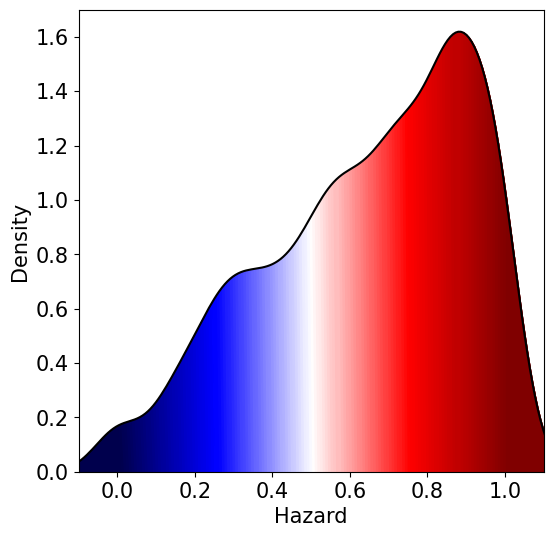

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(6,6))

all_legends = np.concatenate([labeled_data['mean_hazard'].values,unlabeled_data_SNOPES['hazard_pred'].values,unlabeled_data_Enc['hazard_pred'].values])
ax=sns.kdeplot(all_legends,color='k')
plt.xlim([-0.1,1.1])
kde_x, kde_y = ax.lines[0].get_data()
dx=0.007
for x0 in np.arange(-0.1,1.1,dx):
    ax.fill_between(kde_x, kde_y, where=(kde_x>x0) & (kde_x<=x0+3*dx) ,
                interpolate=True, color=plt.cm.seismic(x0))
plt.xlabel('Hazard')


In [ ]:
if False:
  political_scores = pd.read_csv('full_political_scores.csv')
  name2score = {name:score for name,score in political_scores[['screen_name', 'political']].values}
  all_political_names = set(list(name2score.keys()))
data_dir = 'TwitterCOVIDData/'
#files=glob('TwitterCOVIDData/*.csv')

num_data=0
#{'tweet_id':[],'user_pol':[],'date':[],'rt':[],'favs':[],'harm':[]}
for year in range(2020,2022):
  for month in range(1,13):
    for day in range(1,32):
      tweet_stats=[]
      for hour in range(24):
        file = data_dir+'neg_bias_datacoronavirus-clean-'+str(year)+'-'+str(month).zfill(2)+'-'+str(day).zfill(2)+'-'+str(hour).zfill(2)+'.csv'
        if not os.path.exists(file): continue
        data=pd.read_csv(file,lineterminator='\n')
        # we will both track "harm" vs "not harm" rts over time (control for RT user features) AND user political position vs RT/not RT
        # we don't know who saw tweet, did not R
        cols = ['tweetid','rt_tweetid','qtd_tweetid','date','polit_score','harm_tweet','state']
        diff_names = np.intersect1d(data.columns, ['tweet_id','rt_tweet_id','qtd_tweet_id'])
        if len(diff_names)>0:
          if 'tweet_id' in data.columns:
              data['tweetid'] = data['tweet_id']
          if 'rt_tweet_id' in data.columns:
              data['rt_tweetid'] = data['rt_tweet_id']
          if 'qtd_tweet_id' in data.columns:
              data['qtd_tweetid'] = data['qtd_tweet_id']

        for c in cols:
          if c not in data.columns:
            data[c] = [np.nan]*len(data)
        tweet_stats.append(data[cols])
      if len(tweet_stats) > 0:
        tweet_stats = pd.concat(tweet_stats)
        tweet_stats = tweet_stats.reset_index()
        tweet_stats.to_csv(data_dir+'neg_bias_datacoronavirus-clean-'+str(year)+'-'+str(month).zfill(2)+'-'+str(day).zfill(2)+'_subset.csv')

if False:
  for col in ['rt_polit_score','rt_qtd_count', 'rt_rt_count', 'rt_reply_count','rt_fav_count']:
    print(col)
    new_data = data[['harm_tweet',col,'screen_name','rt_tweetid']].dropna()
    new_data = new_data[['harm_tweet',col,'rt_tweetid']].drop_duplicates()
    plt.plot(new_data['harm_tweet'],new_data[col].astype(float),'k.',alpha=0.04)

    plt.yscale('log')

    p,r = spearmanr(new_data['harm_tweet'].astype(float),new_data[col].astype(float))
    plt.ylabel(col)
    plt.xlabel('Harm Label')
    plt.show()



<ipython-input-34-fbbe049c22cd>:17: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv(file,lineterminator='\n')
<ipython-input-34-fbbe049c22cd>:17: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv(file,lineterminator='\n')
<ipython-input-34-fbbe049c22cd>:17: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv(file,lineterminator='\n')
<ipython-input-34-fbbe049c22cd>:17: DtypeWarning: Columns (7,8,9,10,11,12,13,14,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv(file,lineterminator='\n')
<ipython-input-34-fbbe049c22cd>:17: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv(file,lineterminator='\n')
<ipython-input-34-fbbe049c22cd>:17: DtypeWarning: Columns (17) have m

In [ ]:
year=2020
month=1
data_dir = 'TwitterCOVIDData/'
tweet_stats = pd.concat([pd.read_csv(data_dir+'neg_bias_datacoronavirus-clean-'+str(year)+'-'+str(month).zfill(2)+'-'+str(day).zfill(2)+'_subset.csv') for day in range(21,32)])
tweet_stats = tweet_stats.reset_index()
tweet_stats['date'] = pd.to_datetime(tweet_stats['date'])


In [ ]:
type(list(all_ids)[0])

int

In [ ]:
rt_ids = tweet_stats.loc[~np.isnan(tweet_stats['rt_tweetid']),'rt_tweetid'].drop_duplicates().astype(np.int64).values

all_orig_ids = tweet_stats.loc[np.isnan(tweet_stats['rt_tweetid']),'tweetid'].drop_duplicates().astype(np.int64).values
rt_data = {'tweet_id':[],'rt_dates':[],'rt_polit':[],'time_since_orig':[],'harm_tweet':[]}
num_rt_hours = 72
all_ids = set(tweet_stats['tweetid'].dropna().drop_duplicates().values.tolist())

id_tweet_stats = tweet_stats.groupby('tweetid')
all_rt_ids = set(tweet_stats['rt_tweetid'].dropna().drop_duplicates().values.astype(int).tolist())
rt_id_tweet_stats = tweet_stats.groupby('rt_tweetid')
for ii,tweetid in enumerate(set(all_ids).intersection(set(list(all_orig_ids))).intersection(all_rt_ids)):#all_orig_ids):
  if ii % 1000 ==0:
    print(round(ii/len(all_orig_ids)*100,2))
    print(len(rt_data['tweet_id']))
  if ii == 500000:
    break
  #orig = tweet_stats.loc[tweet_stats['tweetid']==tweetid,]
  #if tweetid in all_ids:
  orig = id_tweet_stats.get_group(tweetid)
  #else:
  #    continue
  final_date = np.max(orig['date'].values)
  #all_rts = tweet_stats.loc[tweet_stats['rt_tweetid']==tweetid,]
  #if tweetid in all_rt_ids:
  all_rts = rt_id_tweet_stats.get_group(tweetid)
  #else:
  #    continue
  if len(all_rts) > 0:
    # make sure orig_date < num_rt_hours from end

    #if (orig['date'].values[0] - final_date)/(10**9*60*60) < num_rt_hours: continue
    orig_date = [orig['date'].values[0]]*len(all_rts)
    orig_polit = [orig['polit_score'].values[0]]*len(all_rts)
    polit_values=all_rts['polit_score'].values.tolist()
    dt = ((all_rts['date'].values-orig_date)/(10**9*60*60)).tolist() # hours
    dt = dt[dt < num_rt_hours]
    date = all_rts['date'].values.tolist()

    rt_data['tweet_id']+=[tweetid]*len(all_rts)
    rt_data['rt_dates']+=date
    rt_data['rt_polit']+=polit_values
    rt_data['time_since_orig']+=dt
    rt_data['harm_tweet']+=all_rts['harm_tweet'].values.tolist()
  else:
    rt_data['tweet_id']+=[tweetid]
    rt_data['rt_dates']+=[orig['date'].values[0]]
    rt_data['rt_polit']+=[orig['polit_score'].values[0]]
    rt_data['time_since_orig']+=[np.nan]
    rt_data['harm_tweet']+=[orig['harm_tweet'].values[0]]

rt_data = pd.DataFrame(rt_data)


0.0
0


TypeError: ignored

In [ ]:
orig['date'].values[0]-final_date

numpy.timedelta64(0,'ns')

In [ ]:
#year=2020
#month=1
import pandas as pd
import random
from glob import glob
from scipy.stats import spearmanr
data_dir = 'TwitterCOVIDData/'
files = glob(data_dir+'*.csv')
print(files)
random.shuffle(files)
data=pd.concat([pd.read_csv(file,lineterminator='\n') for file in files[:10]])
data_test = data[['sent_vader','harm_tweet']].dropna().astype(float)
data_test = data_test[pd.to_numeric(data_test['sent_vader'], errors='coerce').notnull()]

#tweet_stats = pd.concat([pd.read_csv(data_dir+'neg_bias_datacoronavirus-clean-'+str(year)+'-'+str(month).zfill(2)+'-'+str(day).zfill(2)+'_subset.csv') for day in range(21,32)])
#tweet_stats = tweet_stats.reset_index()
#tweet_stats['date'] = pd.to_datetime(tweet_stats['date'])


['TwitterCOVIDData/neg_bias_datacoronavirus-clean-2020-02-05-02.csv', 'TwitterCOVIDData/neg_bias_datacoronavirus-clean-2020-03-26-15.csv', 'TwitterCOVIDData/neg_bias_datacoronavirus-clean-2020-05-11-20.csv', 'TwitterCOVIDData/neg_bias_datacoronavirus-clean-2020-05-28-00.csv', 'TwitterCOVIDData/neg_bias_datacoronavirus-clean-2020-06-23-22.csv', 'TwitterCOVIDData/neg_bias_datacoronavirus-clean-2020-09-20-05.csv', 'TwitterCOVIDData/neg_bias_datacoronavirus-clean-2020-11-03-06.csv', 'TwitterCOVIDData/neg_bias_datacoronavirus-clean-2020-12-12-20.csv', 'TwitterCOVIDData/neg_bias_datacoronavirus-clean-2020-12-15-16.csv', 'TwitterCOVIDData/neg_bias_datacoronavirus-clean-2021-01-31-03.csv', 'TwitterCOVIDData/neg_bias_datacoronavirus-clean-2021-05-26-03.csv', 'TwitterCOVIDData/neg_bias_datacoronavirus-clean-2021-06-17-12.csv', 'TwitterCOVIDData/neg_bias_datacoronavirus-clean-2020-01-31-03.csv', 'TwitterCOVIDData/neg_bias_datacoronavirus-clean-2020-04-13-18.csv', 'TwitterCOVIDData/neg_bias_dataco

<ipython-input-6-29678712da28>:11: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.concat([pd.read_csv(file,lineterminator='\n') for file in files[:10]])
<ipython-input-6-29678712da28>:11: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.concat([pd.read_csv(file,lineterminator='\n') for file in files[:10]])
<ipython-input-6-29678712da28>:11: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,40,41,42,44,47,48,49,50,51,52,53,54,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.concat([pd.read_csv(file,lineterminator='\n') for file in files[:10]])
<ipython-input-6-29678712da28>:11: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.concat

TypeError: ignored

In [ ]:
spearmanr(data_test['sent_vader'].astype(float),data_test['harm_tweet'].astype(float))

SignificanceResult(statistic=-0.1911084217986515, pvalue=0.0)

In [ ]:
#spearmanr(data_test['sent_vader'].astype(float),data_test['harm_tweet'].astype(float))
# create emotion model: https://github.com/gchochla/Demux-MEmo


In [ ]:
data_test.loc[[str(s) is not 'nan' and str(h) is not 'nan' for s,h in data_test.values]]

<>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-16-8eab1300e1f2>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  data_test.loc[[str(s) is not 'nan' and str(h) is not 'nan' for s,h in data_test.values]]
<ipython-input-16-8eab1300e1f2>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  data_test.loc[[str(s) is not 'nan' and str(h) is not 'nan' for s,h in data_test.values]]


,sent_vader,harm_tweet
0,0.6407,0.548819
1,0.0,0.422119
2,-0.3818,0.678057
3,-0.4939,0.642452
4,0.0,0.500000
...,...,...
54806,-0.296,0.614809
54807,0.0,0.441974
54808,0.0,0.286926
54809,0.0,0.328656


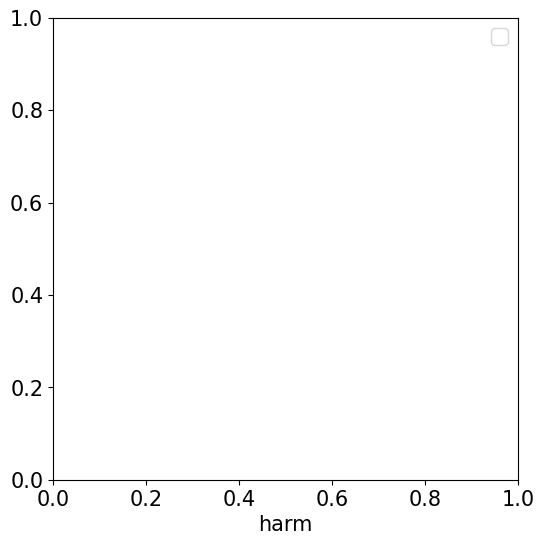

ValueError: ignored

In [ ]:
from scipy.stats import mannwhitneyu
matplotlib.rcParams.update({'font.size': 15})
labelfonts = {'fontname':'Arial','fontsize':15}

fig,ax = plt.subplots(1,1,figsize=(6,6))
non_rt_harm = rt_data.loc[~np.isnan(rt_data['rt_polit']) & np.isnan(rt_data['time_since_orig']),['tweet_id','harm_tweet']].drop_duplicates()['harm_tweet'].values
rt_harm = rt_data.loc[~np.isnan(rt_data['rt_polit']) & ~np.isnan(rt_data['time_since_orig']),['tweet_id','harm_tweet']].drop_duplicates()['harm_tweet'].values
sns.kdeplot(non_rt_harm,color='r',linewidth=3,ax=ax,label='Not Retweeted')
sns.kdeplot(rt_harm,color='b',linestyle='--',linewidth=3,ax=ax,label='Retweeted')
plt.xlabel('harm')
plt.legend(fontsize=15)
plt.show()
print(mannwhitneyu(rt_harm,non_rt_harm))

lib_nort_harm = rt_data.loc[~np.isnan(rt_data['rt_polit']) & np.isnan(rt_data['time_since_orig']) & (rt_data['rt_polit'] < 0.5),['tweet_id','harm_tweet']].drop_duplicates()['harm_tweet'].values
cons_nort_harm = rt_data.loc[~np.isnan(rt_data['rt_polit']) & np.isnan(rt_data['time_since_orig']) & (rt_data['rt_polit'] > 0.5),['tweet_id','harm_tweet']].drop_duplicates()['harm_tweet'].values

lib_rt_harm = rt_data.loc[~np.isnan(rt_data['rt_polit']) & ~np.isnan(rt_data['time_since_orig']) & (rt_data['rt_polit'] < 0.5),['tweet_id','harm_tweet']].drop_duplicates()['harm_tweet'].values
cons_rt_harm = rt_data.loc[~np.isnan(rt_data['rt_polit']) & ~np.isnan(rt_data['time_since_orig']) & (rt_data['rt_polit'] > 0.5),['tweet_id','harm_tweet']].drop_duplicates()['harm_tweet'].values
fig,ax = plt.subplots(1,1,figsize=(6,6))
sns.kdeplot(lib_nort_harm,color='b',linestyle='-',ax=ax,label='lib nort')
sns.kdeplot(cons_nort_harm,color='r',linestyle='--',ax=ax,label='cons nort')

sns.kdeplot(lib_rt_harm,color='c',linestyle='-',ax=ax,label='lib rt')
sns.kdeplot(cons_rt_harm,color='m',linestyle='--',ax=ax,label='cons rt')
plt.xlabel('harm')

plt.legend()
plt.show()
print(mannwhitneyu(lib_rt_harm,cons_rt_harm))

fig,ax = plt.subplots(1,1,figsize=(6,6))
no_harm = rt_data.loc[~np.isnan(rt_data['rt_polit']) & ~np.isnan(rt_data['time_since_orig']) & (rt_data['harm_tweet'] < 0.5),['tweet_id','rt_polit']].drop_duplicates()['rt_polit'].values
harm = rt_data.loc[~np.isnan(rt_data['rt_polit']) & ~np.isnan(rt_data['time_since_orig']) & (rt_data['harm_tweet'] > 0.5),['tweet_id','rt_polit']].drop_duplicates()['rt_polit'].values
sns.kdeplot(no_harm,color='m',linestyle='-',ax=ax,label='no harm')
sns.kdeplot(harm,color='c',linestyle='--',ax=ax,label='harm')
plt.xlabel('partisanship')

plt.legend()
plt.show()
print(mannwhitneyu(no_harm,harm))



In [ ]:
print(mannwhitneyu(no_harm,harm))
print(np.median(harm)-np.median(no_harm))

In [ ]:
print(mannwhitneyu(lib_rt_harm,lib_nort_harm))
print(np.median(lib_rt_harm)-np.median(lib_nort_harm))
print(mannwhitneyu(cons_rt_harm,cons_nort_harm))
print(np.median(cons_rt_harm)-np.median(cons_nort_harm))
print(mannwhitneyu(lib_rt_harm-np.median(lib_nort_harm),cons_rt_harm-np.median(cons_nort_harm)))



In [ ]:
print(mannwhitneyu(lib_rt_harm,cons_rt_harm))
print(np.median(lib_rt_harm)-np.median(cons_rt_harm))
print(mannwhitneyu(lib_nort_harm,cons_nort_harm))
print(np.median(lib_nort_harm)-np.median(cons_nort_harm))

In [ ]:
tweet_stats

In [ ]:
from scipy.stats import mannwhitneyu,spearmanr
rt2num = {}
for tweetid in rt_data['tweet_id'].drop_duplicates().values:
  rts = rt_data.loc[rt_data['tweet_id']==tweetid,'time_since_orig'].dropna()
  num_rts = len(rts)
  rt2num[tweetid] = num_rts
rt_data ['num_rts'] = [rt2num[tweetid] for tweetid in rt_data['tweet_id'].values]
num_rt_vs_harm = rt_data.loc[~np.isnan(rt_data['time_since_orig']) ,['tweet_id','harm_tweet','num_rts']].drop_duplicates()[['harm_tweet','num_rts']]


print(spearmanr(num_rt_vs_harm['harm_tweet'],num_rt_vs_harm['num_rts']))

# compare harm vs emotions, sentiment, morals



In [ ]:
# Phase 1A Data
french_twitter_data = pd.read_csv('Phase 1A Data/AllCombinedTwitterData+text_new.csv')

# because text is identical, we first take the set:
unique_tweets = list(set(french_twitter_data['contentText'].values.tolist()))

model = SentenceTransformer('stsb-xlm-r-multilingual')#'all-mpnet-base-v2')


clf = pk.load(open('finalized_model_SVM.sav','rb'))#SVC(probability=True)
all_pred = []
for tweet in unique_tweets:
    embedding = model.encode(tweet)
    pred_prob = clf.predict_proba([embedding])[:,1]
    all_pred.append(pred_prob)


In [ ]:
dict_pred = {t:p for t,p in zip(unique_tweets,pred_prob)}

french_twitter_data['hazard'] = [dict_pred[t] for t in french_twitter_data['contentText'].values]



In [ ]:
french_twitter_data[['id','contentText','hazard']].to_csv('Phase1AHazards.csv')

In [ ]:
#Sentences are encoded by calling model.encode()
model = SentenceTransformer('stsb-xlm-r-multilingual')#'all-mpnet-base-v2')
df = pd.read_csv('all_5M_features_counts.csv')
embeddings = model.encode(df['text'].values)
#embeddings = model.encode(GT_labels['text'].values)
#GT_labels['embeddings'] = [e for e in embeddings]




<ipython-input-8-03a7e6920fe0>:3: DtypeWarning: Columns (16,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('all_5M_features_counts.csv')


In [ ]:
df['embeddings'] = embeddings

In [ ]:
df.columns

In [ ]:
df['will_rt'] = [rt>0 for rt in df['num_rt_24'].values]

In [ ]:
pk.dump(embeddings,open('rvw_embeddings.pkl','wb'))

In [ ]:
orig_df = df.loc[df['orig'],]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
embedding_dim = 768
#loaded_model = pk.load(open(filename, 'rb'))
#embed_model = SentenceTransformer('stsb-xlm-r-multilingual')#'all-mpnet-base-v2')
#labeled_data['']
#embeddings = embed_model.encode(labeled_data['summary'].values.astype(str))
from tensorflow import keras

#filename = 'finalized_model.sav'
#loaded_model = pk.load(open(filename, 'rb'))

X = embeddings
y = orig_df['will_rt'].values
#index = list(range(len(orig_df)))
#num = labeled_data['number'].values
metrics = {'SVM_pre_f1':[],'SVM_pre_auc':[],'SVM_f1':[],'SVM_auc':[],'RF_pre_f1':[],'RF_pre_auc':[],'RF_f1':[],'RF_auc':[],'XGB_pre_f1':[],'XGB_pre_auc':[],'XGB_f1':[],'XGB_auc':[],'NN_pre_f1':[],'NN_pre_auc':[],'NN_f1':[],'NN_auc':[],'base_f1':[]}
for i in range(50):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i*3141)

  clf = RandomForestClassifier(max_depth=5, random_state=0)
  clf.fit(X, y)


  #num_list = list(np.unique(num))
  #random.shuffle(num_list)
  #train_ind = np.where(np.in1d(num, num_list[:190]))[0]
  #test_ind = np.where(np.in1d(num, num_list[190:]))[0]
  #print(set(list(test_ind)).intersection(set(list(train_ind))))
  # 80% training, 20% testing
  #X_train = X[train_ind]
  #y_train = y[train_ind].round()
  #X_test = X[test_ind]
  #y_test = y[test_ind].round()
  filename = 'finalized_model_SVM.sav'
  loaded_model = pk.load(open(filename, 'rb'))
  f1 = f1_score(y_test,loaded_model.predict(X_test))
  auc = roc_auc_score(y_test,loaded_model.predict_proba(X_test)[:,1])
  metrics['SVM_pre_f1'].append(f1)
  metrics['SVM_pre_auc'].append(auc)
  loaded_model.fit(X_train,y_train)
  new_preds = loaded_model.predict_proba(X_test)[:,1]
  f1 = f1_score(y_test,new_preds.round())
  auc = roc_auc_score(y_test,new_preds)
  print(auc)
  metrics['SVM_f1'].append(f1)
  metrics['SVM_auc'].append(auc)

  filename = 'finalized_model_RF.sav'
  loaded_model = pk.load(open(filename, 'rb'))
  f1 = f1_score(y_test,loaded_model.predict(X_test))
  auc = roc_auc_score(y_test,loaded_model.predict_proba(X_test)[:,1])
  metrics['RF_pre_f1'].append(f1)
  metrics['RF_pre_auc'].append(auc)
  loaded_model.fit(X_train,y_train)
  new_preds = loaded_model.predict_proba(X_test)[:,1]
  f1 = f1_score(y_test,new_preds.round())
  auc = roc_auc_score(y_test.round(),new_preds)
  print(auc)
  metrics['RF_f1'].append(f1)
  metrics['RF_auc'].append(auc)

  filename = 'finalized_model_XGB.sav'
  loaded_model = pk.load(open(filename, 'rb'))
  f1 = f1_score(y_test,loaded_model.predict(X_test))
  auc = roc_auc_score(y_test,loaded_model.predict_proba(X_test)[:,1])
  metrics['XGB_pre_f1'].append(f1)
  metrics['XGB_pre_auc'].append(auc)
  loaded_model.fit(X_train,y_train)
  new_preds = loaded_model.predict_proba(X_test)[:,1]
  f1 = f1_score(y_test,new_preds.round())
  auc = roc_auc_score(y_test,new_preds)
  print(auc)
  metrics['XGB_f1'].append(f1)
  metrics['XGB_auc'].append(auc)

  loaded_model = keras.models.load_model('finalized_model_NN.sav')
  embedding_normalizer = Normalization(input_shape=[embedding_dim,], axis=None)
  embedding_normalizer.adapt(X_train)
  def modeling(l2_lambda=0.001, relu_alpha=0.1, dropout_rate=0.7):
      model = Sequential([
      embedding_normalizer,
      Dense(int(embedding_dim/3),kernel_regularizer=regularizers.l2(l2_lambda)),
      LeakyReLU(relu_alpha), #alpha=negative coefficient for the slope
      BatchNormalization(),
      Dropout(dropout_rate),
      Dense(int(embedding_dim/9), kernel_regularizer=regularizers.l2(l2_lambda)),
      LeakyReLU(relu_alpha),
      BatchNormalization(),
      Dropout(dropout_rate),
      Dense(int(embedding_dim/27),kernel_regularizer=regularizers.l2(l2_lambda)),
      LeakyReLU(relu_alpha),
      BatchNormalization(),
      Dropout(dropout_rate),
      #Dense(int(embedding_dim/16),kernel_regularizer=regularizers.l2(l2_lambda)),
      #LeakyReLU(relu_alpha),
      #BatchNormalization(),
      #Dropout(dropout_rate),
      Dense(1, activation=tf.keras.activations.sigmoid)
      ])
      model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['binary_crossentropy',AUC()])
      return model

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5) #min_delta=1 #baseline=26
  y_pred = loaded_model.predict(X_test)
  metrics['NN_pre_auc'].append(roc_auc_score(y_test, y_pred))
  metrics['NN_pre_f1'].append(f1_score(y_test,y_pred.round()))
  history = loaded_model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=32, verbose=2,callbacks=[es]) #callbacks=[es])
  y_pred = loaded_model.predict(X_test)
  metrics['NN_auc'].append(roc_auc_score(y_test, y_pred))
  metrics['NN_f1'].append(f1_score(y_test,y_pred.round()))

  f1_base=f1_score(y_test,[1]*len(y_test))
  metrics['base_f1'].append(f1_base)

pd.DataFrame(metrics).to_csv('UL_metrics.csv',index=False)


embedding_dim = 768
#loaded_model = pk.load(open(filename, 'rb'))
embed_model = SentenceTransformer('stsb-xlm-r-multilingual')#'all-mpnet-base-v2')
#labeled_data['']
embeddings = embed_model.encode(labeled_data['summary'].values.astype(str))
from tensorflow import keras

#embed_model = SentenceTransformer('all-mpnet-base-v2')
#labeled_data['']
#embeddings = embed_model.encode(labeled_data['Claim'].values.astype(str))
X = embeddings
y = labeled_data['hazard'].values.round()

model = keras.models.load_model('finalized_model_NN.sav')
embedding_normalizer = Normalization(input_shape=[embedding_dim,], axis=None)
embedding_normalizer.adapt(X)
def modeling(l2_lambda=0.001, relu_alpha=0.1, dropout_rate=0.7):
    model = Sequential([
    embedding_normalizer,
    Dense(int(embedding_dim/3),kernel_regularizer=regularizers.l2(l2_lambda)),
    LeakyReLU(relu_alpha), #alpha=negative coefficient for the slope
    BatchNormalization(),
    Dropout(dropout_rate),
    Dense(int(embedding_dim/9), kernel_regularizer=regularizers.l2(l2_lambda)),
    LeakyReLU(relu_alpha),
    BatchNormalization(),
    Dropout(dropout_rate),
    Dense(int(embedding_dim/27),kernel_regularizer=regularizers.l2(l2_lambda)),
    LeakyReLU(relu_alpha),
    BatchNormalization(),
    Dropout(dropout_rate),
    #Dense(int(embedding_dim/16),kernel_regularizer=regularizers.l2(l2_lambda)),
    #LeakyReLU(relu_alpha),
    #BatchNormalization(),
    #Dropout(dropout_rate),
    Dense(1, activation=tf.keras.activations.sigmoid)
    ])
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['binary_crossentropy',AUC()])
    return model

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5) #min_delta=1 #baseline=26
history = model.fit(X, y, validation_split=0.1, epochs=100, batch_size=32, verbose=2,callbacks=[es]) #callbacks=[es])


model.save('finalized_model_NN_UL.sav')